# Imports and Installs

## Installs

In [ ]:
! pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00


In [ ]:
! pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=4d99f028d5f0df82cabab3530bcbebcef20a0643412f5b149e4dae15ddf7ebae
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


## Imports

In [ ]:
import evaluate
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

from copy import deepcopy
from keras.callbacks import ModelCheckpoint
from keras.layers import Bidirectional, Dense, Dropout, Embedding, LSTM
from keras.models import load_model, Sequential
from sklearn.model_selection import KFold
from sklearn.naive_bayes import CategoricalNB
from sklearn.preprocessing import OneHotEncoder

## Downloads

In [ ]:
# Downloads
scorer_bleu = evaluate.load("bleu")
scorer_rouge = evaluate.load('rouge')
del scorer_bleu
del scorer_rouge

# Suppress Warnings

In [ ]:
# Turn off pandas warnings
pd.options.mode.chained_assignment = None  # default='warn'

# Global Variables

In [2]:
# Directory info
PROJECT_DIR = "/content/drive/MyDrive/Classes/CSCE 5810 BioComputing/5810 Group Project/" # Mica
# PROJECT_DIR = ""  # Camrie
DATA_DIR = PROJECT_DIR + "Data/"

# Data
DATASET_NAMES = ["kaggle"]
SUBSET_NAMES = ["seqs", "activity", "nums"]
NUMS_NAMES = ["Dif_5-3", "A", "C", "G", "U", "Cons_Sum"]

# Maps
START_TOKEN = "$"
END_TOKEN = "#"
PAD_TOKEN = "0"
GENE_VOCAB = [PAD_TOKEN, START_TOKEN, END_TOKEN, "A", "C", "G", "T"]
SIRNA_VOCAB = [PAD_TOKEN, START_TOKEN, END_TOKEN, "A", "C", "G", "U"]
GENE_TOKEN_TO_ID = {}
GENE_ID_TO_TOKEN = {}
SIRNA_TOKEN_TO_ID = {}
SIRNA_ID_TO_TOKEN = {}

# Training
SEQUENCE_LENGTH = None
WINDOW_SIZE = 5
K_FOLDS = 5
EMBEDDING_DIM = 128
NUM_UNITS = 256
NUM_HEADS = 4
NUM_ENC_DEC_LAYERS = 2
DROPOUT_RATE = 0.1
BATCH_SIZE = 20
EPOCHS = 10
CROSS_FOLDS = 5

In [ ]:
# Build maps
for i, tok in enumerate(GENE_VOCAB):
    GENE_TOKEN_TO_ID.update({tok: i})
    GENE_ID_TO_TOKEN.update({i: tok})
for i, tok in enumerate(SIRNA_VOCAB):
    SIRNA_TOKEN_TO_ID.update({tok: i})
    SIRNA_ID_TO_TOKEN.update({i: tok})

# Load Data

In [ ]:
# Load kaggle data
kaggle = {}
for ratio in ["80", "90"]:
    for split in ["train", "test"]:
        for sub in SUBSET_NAMES:
            k = ratio + "_" + split + "_" + sub
            f_name = DATA_DIR + "kaggle_df_" + k + ".csv"
            if os.path.exists(f_name):
                kaggle.update({k: pd.read_csv(f_name)})
            else:
                print("ERROR: File %s wasn't found."%(f_name))

# Utility Functions

In [ ]:
def gene_tokens_to_ids(tokens):
    idxs = []
    for tok in tokens:
        idxs.append(GENE_TOKEN_TO_ID[tok])
    return idxs

def gene_ids_to_tokens(idxs):
    tokens = []
    for i in idxs:
        tokens.append(GENE_ID_TO_TOKEN[i])
    return tokens

def sirna_tokens_to_ids(tokens):
    idxs = []
    for tok in tokens:
        idxs.append(SIRNA_TOKEN_TO_ID[tok])
    return idxs

def sirna_ids_to_tokens(idxs):
    tokens = []
    for i in idxs:
        tokens.append(SIRNA_ID_TO_TOKEN[i])
    return tokens

# Preprocess Data

## Naive Bayes

In [ ]:
def window_sequence(record, window_size):
    start = record["Start"]
    end = record["End"]
    gene = record["Target gene"]
    sirna = record["Sequence"]

    # Build windows
    windows = []
    sirna_b = []
    for i, tok in enumerate(sirna):
        w = [c for c in gene[record["Start"] - window_size + i:record["Start"] + i]]
        windows.append(w)
        sirna_b.append(tok)

    return windows, sirna_b

In [ ]:
def preprocess_nb_sequence(record, window_size, nums=False):

    # Window sequence
    windows, sirna_b = window_sequence(record, window_size)

    # One-hot encoding
    ohe = OneHotEncoder(categories=[GENE_VOCAB for i in range(len(windows[0]))])
    ohe.fit(windows)
    windows = ohe.transform(windows).toarray().tolist()

    # Add nums
    if nums:
        nums_row = []
        for k in NUMS_NAMES:
            nums_row.append(record[k])
        windows_new = []
        for i, row in enumerate(windows):
            windows[i] = windows[i] + nums_row

    return windows, sirna_b

In [ ]:
def preprocess_nb(df, window_size, nums=False):

    # Window and preprocess all rows
    gene = []
    sirna = []
    singles = []
    for i, row in df.iterrows():

        # Skip rows where the start - window_size is not a valid index
        if row["Start"] - window_size > -1:

            # Get windows and sirna with preprocessing
            windows, sirna_b = preprocess_nb_sequence(row, window_size, nums)

            # Save
            gene.extend(windows)
            sirna += sirna_b
            singles.append([windows, sirna_b])

    return gene, sirna, singles

## LSTM

In [ ]:
def preprocess_lstm(df, nums=False):

    # Get substrings of gene
    df["gene"] = df.apply(lambda x: x["Target gene"][x["Start"]:x["End"]+1], axis=1)
    df = df.loc[df["gene"].str.len() == df["Sequence"].str.len()]

    # Pad columns
    max_l = df["Sequence"].str.len().max()
    df["gene"] = df["gene"].str.pad(width=max_l, side="right", fillchar=PAD_TOKEN)
    df["sirna"] = df["Sequence"].str.pad(width=max_l, side="right", fillchar=PAD_TOKEN)

    # # Encode sequences
    df["gene"] = df.apply(lambda x: gene_tokens_to_ids(x["gene"]), axis=1)
    df["sirna"] = df.apply(lambda x: sirna_tokens_to_ids(x["sirna"]), axis=1)

    # Convert to lists
    gene = []
    sirna = []
    for i, row in df.iterrows():
        gene.append([GENE_TOKEN_TO_ID[START_TOKEN]] + row["gene"] + [GENE_TOKEN_TO_ID[END_TOKEN]])
        sirna.append([SIRNA_TOKEN_TO_ID[START_TOKEN]] + row["sirna"] + [SIRNA_TOKEN_TO_ID[END_TOKEN]])

        # Keep numerical features if selected
        if nums:
            for k in NUMS_NAMES:
                gene[-1].append(row[k])
                sirna[-1].append(SIRNA_TOKEN_TO_ID[PAD_TOKEN])

    max_l = len(gene[0])
    return np.array(gene), np.array(sirna), max_l

## Transformer

In [ ]:
def preprocess_transformer(df, nums=False):

    # Apply LSTM preprocessor
    gene, sirna, l = preprocess_lstm(df, nums)

    return gene, sirna, l

## Apply Functions

In [ ]:
data_preprocessed = {"nb": {},
                     "lstm": {},
                     "transformer": {}
                     }

In [ ]:
# Iterate
for ratio in ["80", "90"]:
    for split in ["train", "test"]:
        for sub in SUBSET_NAMES:
            k = ratio + "_" + split + "_" + sub
            nums = "nums" in k

            # Naive Bayes preprocessing
            gene, sirna, singles = preprocess_nb(deepcopy(kaggle[k]), WINDOW_SIZE, nums)
            data_preprocessed["nb"].update({k: {"gene": gene, "sirna": sirna, "singles": singles}})

            # LSTM preprocessing
            gene, sirna, l = preprocess_lstm(deepcopy(kaggle[k]), nums)
            data_preprocessed["lstm"].update({k: {"gene": gene, "sirna": sirna, "len": l}})

            # Transformer preprocessing
            gene, sirna, l = preprocess_transformer(deepcopy(kaggle[k]), nums)
            data_preprocessed["transformer"].update({k: {"gene": gene, "sirna": sirna, "len": l}})

# Model Handlers

## Naive Bayes

In [ ]:
class NaiveBayesHandler():

    def __init__(self, model_name, alpha=1.0, force_alpha=False):

        # Variables
        self.model_name = model_name
        self.results = {"val": {},
                        "test": {}}

        # Model
        self.model = CategoricalNB(alpha=alpha, force_alpha=force_alpha)

        # Scorers
        self.scorer_bleu = evaluate.load("bleu")
        self.scorer_rouge = evaluate.load("rouge")

    def train_model(self, train_x, train_y, val_x, val_y):
        print("Beginning training...")

        # Fit model
        self.model.fit(train_x, train_y)

        # Get validation results
        if val_x is not None and val_y is not None:
            preds = self.model.predict(val_x)
            acc = self.model.score(val_x, val_y)
            self.results["val"].update({len(self.results["val"]):
                                        {"acc": acc}
                                        })
            print("Val. Accuracy:", acc*100)

    def k_fold_training(self, folds, train_x, train_y):

        # Get data folds
        kf = KFold(n_splits=folds)
        for i, (train_i, test_i) in enumerate(kf.split(train_x)):
            print("\nTraining Fold", i+1)
            train_x_fold = [train_x[idx] for idx in train_i]
            train_y_fold = [train_y[idx] for idx in train_i]
            val_x_fold = [train_x[idx] for idx in test_i]
            val_y_fold = [train_y[idx] for idx in test_i]

            # Train
            self.train_model(train_x_fold, train_y_fold, val_x_fold, val_y_fold)
        print("\nFinal Training")
        self.train_model(train_x, train_y, None, None)

    def predict_sequence(self, windows):
        return self.model.predict(windows)

    def test_model(self, test_single, test_x, test_y):
        preds = []
        true = []

        # Get predictions
        for row in test_single:
            p = self.predict_sequence(row[0])
            preds.append(p)
            true.append(row[1])

        # Score model
        acc = self.model.score(test_x, test_y)

        # Hamming scores
        ham_min = 1000
        ham_max = 0
        ham_avg = 0
        for i in range(len(true)):
            ham = 0
            for j in range(len(true[i])):
                if true[i][j] != preds[i][j]:
                    ham += 1
            ham_avg += ham
            if ham < ham_min:
                ham_min = ham
            if ham > ham_max:
                ham_max = ham
        ham_avg /= len(true)

        # Score model NLP metrics
        preds = [" ".join(row) for row in preds]
        true = [" ".join(row) for row in true]
        results_bleu = self.scorer_bleu.compute(predictions=preds, references=true)
        results_rouge = self.scorer_rouge.compute(predictions=preds, references=true)


        self.results["test"] = {"accuracy": acc,
                                "hamming_min": ham_min,
                                "hamming_max": ham_max,
                                "hamming_avg": ham_avg,
                                "bleu": results_bleu["bleu"],
                                "rouge_1": results_rouge["rouge1"],
                                "rouge_2": results_rouge["rouge2"],
                                "rouge_l": results_rouge["rougeL"],
                                "rouge_s": results_rouge["rougeLsum"]
                                }
        return self.results["test"]

## LSTM

https://www.kaggle.com/code/harshjain123/machine-translation-seq2seq-lstms

https://medium.com/@saikrishna4820/lstm-language-translation-18c076860b23

In [ ]:
class LSTMHandler():

    def __init__(self, model_name, model_units, input_length, display=True):

        # Variables
        self.model_name = model_name
        self.units = model_units
        self.input_length = input_length
        self.filename = "checkpoint_lstm_%s.ckpt"%self.model_name
        self.history = []
        self.results = {"val": {},
                        "test": {}}

        # Scorers
        self.scorer_bleu = evaluate.load("bleu")
        self.scorer_rouge = evaluate.load("rouge")

        # Build model
        self.build_model(display)

    def build_model(self, display=True):

        # Define model
        self.model = Sequential([
            Embedding(len(GENE_VOCAB), self.units, input_length=self.input_length, mask_zero=True),
            Bidirectional(LSTM(self.units, activation="relu", return_sequences=True)),
            Dropout(DROPOUT_RATE),
            Bidirectional(LSTM(int(self.units/2), activation="relu", return_sequences=True)),
            Dropout(DROPOUT_RATE),
            Dense(len(SIRNA_VOCAB), activation="softmax")
        ])

        # Compile model
        self.model.compile(optimizer=tf.keras.optimizers.Adam(),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                           metrics=["accuracy"]
                           )

        # View
        if display:
            self.model.summary()
            print()

    def train_model(self, train_x, train_y, val_x, val_y, epochs, batch_size, shuffle=True):
        print("Beginning training...")
        h = None

        # Set up checkpointing
        checkpoint= ModelCheckpoint(self.filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

        # Handle validation data missing
        if val_x is None or val_y is None:
            h = self.model.fit(train_x,
                               train_y.reshape(train_y.shape[0], train_y.shape[1], 1),
                               validation_split=0.2,
                               epochs=epochs,
                               batch_size=batch_size,
                               callbacks=[checkpoint],
                               shuffle=shuffle
                               )

        # Train with validation data
        else:
            h = self.model.fit(train_x,
                               train_y.reshape(train_y.shape[0], train_y.shape[1], 1),
                               validation_data=(val_x, val_y),
                               epochs=epochs,
                               batch_size=batch_size,
                               callbacks=[checkpoint],
                               shuffle=shuffle
                               )

        # Save history
        self.history.append(h)

        # Load best model
        self.model = load_model(self.filename)

    def k_fold_training(self, folds, train_x, train_y, epochs, batch_size, shuffle=True):

        # Get data folds
        kf = KFold(n_splits=folds)
        for i, (train_i, test_i) in enumerate(kf.split(train_x)):
            print("\nTraining Fold", i+1)
            train_x_fold = np.array(list(train_x[train_i]), dtype=np.int32)
            train_y_fold = np.array(list(train_y[train_i]), dtype=np.int32)
            val_x_fold = np.array(list(train_x[test_i]), dtype=np.int32)
            val_y_fold = np.array(list(train_y[test_i]), dtype=np.int32)

            # Train
            self.train_model(train_x_fold, train_y_fold, val_x_fold, val_y_fold, epochs, batch_size, shuffle)
        print("\nFinal Training")
        self.train_model(train_x, train_y, None, None, epochs, batch_size, shuffle)

    def test_model(self, test_x, test_y):

        # Get predictions
        preds_p = self.model.predict(test_x.reshape((test_x.shape[0], test_x.shape[1])))

        # Convert to binary
        preds_s = []
        preds_i = []
        for i in range(len(preds_p)):
            p = []
            for pos in preds_p[i]:
                p.append(np.argmax(pos))
            preds_i.append(p)

            # Convert to strings
            preds_s.append(sirna_ids_to_tokens(p))

        # Get scores
        eval = self.model.evaluate(x=test_x,
                                   y=test_y,
                                   return_dict=True
                                   )
        acc = eval["accuracy"]

        # Hamming scores
        ham_min = 1000
        ham_max = 0
        ham_avg = 0
        for i in range(len(test_y)):
            ham = 0
            for j in range(len(test_y[i])):
                if test_y[i][j] != preds_i[i][j]:
                    ham += 1
            ham_avg += ham
            if ham < ham_min:
                ham_min = ham
            if ham > ham_max:
                ham_max = ham
        ham_avg /= len(test_y)

        # Score model NLP metrics
        # https://medium.com/@sthanikamsanthosh1994/understanding-bleu-and-rouge-score-for-nlp-evaluation-1ab334ecadcb#:~:text=While%20BLEU%20score%20is%20primarily,the%20reference%20translations%20or%20summaries.
        preds_s = [" ".join(row) for row in preds_s]
        refs_s = [" ".join(sirna_ids_to_tokens(row)) for row in test_y]
        results_bleu = self.scorer_bleu.compute(predictions=preds_s, references=refs_s)
        results_rouge = self.scorer_rouge.compute(predictions=preds_s, references=refs_s)


        self.results["test"] = {"accuracy": acc,
                                "hamming_min": ham_min,
                                "hamming_max": ham_max,
                                "hamming_avg": ham_avg,
                                "bleu": results_bleu["bleu"],
                                "rouge_1": results_rouge["rouge1"],
                                "rouge_2": results_rouge["rouge2"],
                                "rouge_l": results_rouge["rougeL"],
                                "rouge_s": results_rouge["rougeLsum"]
                                }
        return self.results["test"]

## Transformer

### From Tutorial

https://www.tensorflow.org/text/tutorials/transformer

In [ ]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
            ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                        num_heads=num_heads,
                        dff=dff,
                        dropout_rate=dropout_rate)
            for _ in range(num_layers)
            ]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                                 d_model=d_model
                                                 )
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate
                         )
            for _ in range(num_layers)
            ]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers,
                               d_model=d_model,
                               num_heads=num_heads,
                               dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate
                               )

        self.decoder = Decoder(num_layers=num_layers,
                               d_model=d_model,
                               num_heads=num_heads,
                               dff=dff,
                               vocab_size=target_vocab_size,
                               dropout_rate=dropout_rate
                               )

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        context, x  = inputs

        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

### Custom

In [ ]:
def prepare_batch(gene, sirna):

    # Reshape gene to mathc shape (drop start token)
    gene = gene[:, 1:]

    # Drop start token
    sirna_label = sirna[:, 1:]

    # Drop end token
    sirna = sirna[:, :-1]

    return (gene, sirna), sirna_label

In [ ]:
class TransformerHandler():

    def __init__(self, model_name, num_layers, d_model, dff, num_heads, dropout, init_x, init_y, display=True):

        # Variables
        self.model_name = model_name
        self.num_layers = num_layers
        self.d_model = d_model
        self.dff = dff
        self.num_heads = num_heads
        self.dropout_rate = dropout
        self.filename = "checkpoint_transformer_%s.ckpt"%self.model_name
        self.history = []
        self.results = {"val": {},
                        "test": {}
                        }

        # Scorers
        self.scorer_bleu = evaluate.load("bleu")
        self.scorer_rouge = evaluate.load("rouge")

        # Build model
        self.build_model(init_x, init_y, display)

    def build_model(self, init_x, init_y, display=True):

        # Define model
        self.model = Transformer(num_layers=self.num_layers,
                                 d_model=self.d_model,
                                 num_heads=self.num_heads,
                                 dff=self.dff,
                                 input_vocab_size=len(GENE_VOCAB),
                                 target_vocab_size=len(SIRNA_VOCAB),
                                 dropout_rate=self.dropout_rate
                                 )

        # Initilize model
        out = self.model((init_x, init_y))

        # Compile model
        self.model.compile(optimizer=tf.keras.optimizers.Adam(),
                           loss=masked_loss,
                           metrics=[masked_accuracy]
                           )

        # View
        if display:
            self.model.summary()
            print()

    def train_model(self, train_x, train_y, val_x, val_y, epochs, batch_size, shuffle=True):
        print("Beginning training...")
        h = None

        # Train with validation data
        dataset_train = tf.data.Dataset.from_tensor_slices((train_x, train_y))
        dataset_train = dataset_train.batch(BATCH_SIZE).map(prepare_batch, tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)
        dataset_val = tf.data.Dataset.from_tensor_slices((val_x, val_y))
        dataset_val = dataset_val.batch(BATCH_SIZE).map(prepare_batch, tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)
        h = self.model.fit(dataset_train,
                            validation_data=dataset_val,
                            epochs=epochs
                            )

        # Save history
        self.history.append(h)

    def k_fold_training(self, folds, train_x, train_y, epochs, shuffle=True):

        # Get data folds
        kf = KFold(n_splits=folds)
        for i, (train_i, test_i) in enumerate(kf.split(train_x)):
            print("\nTraining Fold", i+1)
            train_x_fold = np.array(list(train_x[train_i]), dtype=np.int32)
            train_y_fold = np.array(list(train_y[train_i]), dtype=np.int32)
            val_x_fold = np.array(list(train_x[test_i]), dtype=np.int32)
            val_y_fold = np.array(list(train_y[test_i]), dtype=np.int32)

            # Train
            self.train_model(train_x_fold, train_y_fold, val_x_fold, val_y_fold, epochs, shuffle)

    def test_model(self, test_x, test_y):

        # Get predictions
        print("Starting prediction generation...")
        # FROM TUORIAL WITH MODIFICATION =======================================
        preds = []
        for i, row in enumerate(test_x):
            print("%d / %d"%(i + 1, len(test_x)))

            output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
            output_array = output_array.write(0, [GENE_TOKEN_TO_ID[START_TOKEN]])
            for i in tf.range(len(test_y[0]) - 1):
                output = tf.transpose(output_array.stack())
                predictions = self.model([tf.constant([row[1:]]), output], training=False)

                # Select the last token from the `seq_len` dimension.
                predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

                predicted_id = tf.argmax(predictions, axis=-1)

                # Concatenate the `predicted_id` to the output which is given to the
                # decoder as its input.
                output_array = output_array.write(i+1, predicted_id[0])

                if predicted_id == SIRNA_TOKEN_TO_ID[END_TOKEN]:
                    break
            output = tf.transpose(output_array.stack())
            preds.append(output.numpy()[0])
            # END FROM TUORIAL WITH MODIFICATION ===============================
            # break

        # Convert to strings
        preds_s = []
        for i, p in enumerate(preds):
            preds_s.append(sirna_ids_to_tokens(p))

        # Hamming scores
        ham_min = 1000
        ham_max = 0
        ham_avg = 0
        # print(test_y[0])
        # print(len(test_y[0]))
        # print(preds[0])
        # print(len(preds[0]))
        for i in range(len(preds)):
            ham = 0
            for j in range(len(preds[i])):
                if test_y[i][j] != preds[i][j]:
                    ham += 1
            ham_avg += ham
            if ham < ham_min:
                ham_min = ham
            if ham > ham_max:
                ham_max = ham
        ham_avg /= len(preds)

        # Score model NLP metrics
        # https://medium.com/@sthanikamsanthosh1994/understanding-bleu-and-rouge-score-for-nlp-evaluation-1ab334ecadcb#:~:text=While%20BLEU%20score%20is%20primarily,the%20reference%20translations%20or%20summaries.
        preds_s = [" ".join(row) for row in preds_s]
        refs_s = [" ".join(sirna_ids_to_tokens(row)) for row in test_y]
        results_bleu = self.scorer_bleu.compute(predictions=preds_s, references=refs_s)
        results_rouge = self.scorer_rouge.compute(predictions=preds_s, references=refs_s)


        self.results["test"] = {"hamming_min": ham_min,
                                "hamming_max": ham_max,
                                "hamming_avg": ham_avg,
                                "bleu": results_bleu["bleu"],
                                "rouge_1": results_rouge["rouge1"],
                                "rouge_2": results_rouge["rouge2"],
                                "rouge_l": results_rouge["rougeL"],
                                "rouge_s": results_rouge["rougeLsum"]
                                }
        return self.results["test"]

# Experiments

## Functions

### Naive Bayes Experiment

In [ ]:
def experiment_nb(data, set_key):
    train_key = "80_train_%s"%(set_key)
    test_key = "80_test_%s"%(set_key)
    model_name = "nb_%s"%(set_key)

    handler_nb = NaiveBayesHandler(model_name)
    handler_nb.k_fold_training(K_FOLDS,
                               data[train_key]["gene"],
                               data[train_key]["sirna"]
                               )

    handler_nb.test_model(data[test_key]["singles"],
                          data[test_key]["gene"],
                          data[test_key]["sirna"]
                          )
    return handler_nb

### LSTM Experiment

In [ ]:
def experiment_lstm(data, set_key, units, display=True):
    train_key = "80_train_%s"%(set_key)
    test_key = "80_test_%s"%(set_key)
    model_name = "lstm_%s"%(set_key)

    input_len = data[train_key]["len"]
    handler_lstm = LSTMHandler(model_name, units, input_len, display=display)
    handler_lstm.k_fold_training(folds=K_FOLDS,
                                 train_x=data[train_key]["gene"],
                                 train_y=data[train_key]["sirna"],
                                 epochs=EPOCHS,
                                 batch_size=BATCH_SIZE
                                 )
    handler_lstm.test_model(test_x=data[test_key]["gene"],
                                  test_y=data[test_key]["sirna"]
                                  )
    return handler_lstm

### Transformer Experiment

In [ ]:
def experiment_transformer(data, set_key):
    train_key = "80_train_%s"%(set_key)
    test_key = "80_test_%s"%(set_key)
    model_name = "transformer_%s"%(set_key)

    dataset = tf.data.Dataset.from_tensor_slices((data[train_key]["gene"], data[train_key]["sirna"]))
    dataset = dataset.batch(BATCH_SIZE)
    for init_x, init_y in dataset.take(1):
        break

    handler_transformer = TransformerHandler(model_name,
                                             num_layers=NUM_ENC_DEC_LAYERS,
                                             d_model=EMBEDDING_DIM,
                                             dff=NUM_UNITS,
                                             num_heads=NUM_HEADS,
                                             dropout=DROPOUT_RATE,
                                             init_x=deepcopy(init_x),
                                             init_y=deepcopy(init_y))
    handler_transformer.k_fold_training(folds=K_FOLDS,
                                        train_x=data[train_key]["gene"],
                                        train_y=data[test_key]["sirna"],
                                        epochs=EPOCHS
                                        )
    handler_transformer.test_model(test_x=data[test_key]["gene"],
                                   test_y=data[test_key]["sirna"]
                                   )
    return handler_transformer

## Run Experiments

In [ ]:
handlers = {}

### Naive Bayes

In [ ]:
k = "seqs"
handlers.update({"nb_%s"%(k): experiment_nb(data_preprocessed["nb"], k)})


Training Fold 1
Beginning training...
Val. Accuracy: 30.073561228905238

Training Fold 2
Beginning training...
Val. Accuracy: 28.169623539593246

Training Fold 3
Beginning training...
Val. Accuracy: 29.567099567099568

Training Fold 4
Beginning training...
Val. Accuracy: 29.22077922077922

Training Fold 5
Beginning training...
Val. Accuracy: 28.484848484848484

Final Training
Beginning training...


In [ ]:
k = "activity"
handlers.update({"nb_%s"%(k): experiment_nb(data_preprocessed["nb"], k)})


Training Fold 1
Beginning training...
Val. Accuracy: 30.082358040745554

Training Fold 2
Beginning training...
Val. Accuracy: 28.218465539661896

Training Fold 3
Beginning training...
Val. Accuracy: 29.518855656697006

Training Fold 4
Beginning training...
Val. Accuracy: 29.35819601040763

Training Fold 5
Beginning training...
Val. Accuracy: 28.44752818733738

Final Training
Beginning training...


In [ ]:
k = "nums"
handlers.update({"nb_%s"%(k): experiment_nb(data_preprocessed["nb"], k)})


Training Fold 1
Beginning training...
Val. Accuracy: 30.549545651233235

Training Fold 2
Beginning training...
Val. Accuracy: 29.55430549545651

Training Fold 3
Beginning training...
Val. Accuracy: 29.956709956709958

Training Fold 4
Beginning training...
Val. Accuracy: 29.740259740259738

Training Fold 5
Beginning training...
Val. Accuracy: 28.18181818181818

Final Training
Beginning training...


### LSTM

In [ ]:
k = "seqs"
handlers.update({"lstm_%s"%(k): experiment_lstm(data_preprocessed["lstm"], k, NUM_UNITS)})

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 21, 256)           1792      
                                                                 
 bidirectional (Bidirection  (None, 21, 512)           1050624   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 21, 512)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 21, 256)           656384    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 21, 256)           0         
                                                                 
 dense (Dense)               (None, 21, 7)             1


Training Fold 2
Beginning training...
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.2369 - accuracy: 0.3860
Epoch 1: val_loss improved from inf to 1.22412, saving model to checkpoint_lstm_lstm_seqs.ckpt
25/25 [==============================] - 24s 718ms/step - loss: 1.2369 - accuracy: 0.3860 - val_loss: 1.2241 - val_accuracy: 0.3977
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.2270 - accuracy: 0.3893
Epoch 2: val_loss did not improve from 1.22412
25/25 [==============================] - 8s 326ms/step - loss: 1.2270 - accuracy: 0.3893 - val_loss: 1.2277 - val_accuracy: 0.3954
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 1.2260 - accuracy: 0.3935
Epoch 3: val_loss improved from 1.22412 to 1.21819, saving model to checkpoint_lstm_lstm_seqs.ckpt
25/25 [==============================] - 15s 610ms/step - loss: 1.2260 - accuracy: 0.3935 - val_loss: 1.2182 - val_accuracy: 0.4067
Epoch 4/10
25/25 [=========================


Training Fold 3
Beginning training...
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.2223 - accuracy: 0.4025
Epoch 1: val_loss improved from inf to 1.21953, saving model to checkpoint_lstm_lstm_seqs.ckpt
25/25 [==============================] - 23s 664ms/step - loss: 1.2223 - accuracy: 0.4025 - val_loss: 1.2195 - val_accuracy: 0.4020
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.2203 - accuracy: 0.3999
Epoch 2: val_loss did not improve from 1.21953
25/25 [==============================] - 8s 305ms/step - loss: 1.2203 - accuracy: 0.3999 - val_loss: 1.2201 - val_accuracy: 0.4059
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 1.2137 - accuracy: 0.4086
Epoch 3: val_loss improved from 1.21953 to 1.21249, saving model to checkpoint_lstm_lstm_seqs.ckpt
25/25 [==============================] - 15s 624ms/step - loss: 1.2137 - accuracy: 0.4086 - val_loss: 1.2125 - val_accuracy: 0.4075
Epoch 4/10
25/25 [=========================


Training Fold 4
Beginning training...
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.2142 - accuracy: 0.4109
Epoch 1: val_loss improved from inf to 1.20001, saving model to checkpoint_lstm_lstm_seqs.ckpt
25/25 [==============================] - 24s 628ms/step - loss: 1.2142 - accuracy: 0.4109 - val_loss: 1.2000 - val_accuracy: 0.4124
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.2049 - accuracy: 0.4133
Epoch 2: val_loss did not improve from 1.20001
25/25 [==============================] - 5s 199ms/step - loss: 1.2049 - accuracy: 0.4133 - val_loss: 1.2106 - val_accuracy: 0.4046
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 1.2040 - accuracy: 0.4158
Epoch 3: val_loss improved from 1.20001 to 1.19381, saving model to checkpoint_lstm_lstm_seqs.ckpt
25/25 [==============================] - 16s 661ms/step - loss: 1.2040 - accuracy: 0.4158 - val_loss: 1.1938 - val_accuracy: 0.4144
Epoch 4/10
25/25 [=========================


Training Fold 5
Beginning training...
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.2041 - accuracy: 0.4163
Epoch 1: val_loss improved from inf to 1.21305, saving model to checkpoint_lstm_lstm_seqs.ckpt
25/25 [==============================] - 23s 630ms/step - loss: 1.2041 - accuracy: 0.4163 - val_loss: 1.2131 - val_accuracy: 0.4195
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.2074 - accuracy: 0.4146
Epoch 2: val_loss improved from 1.21305 to 1.20547, saving model to checkpoint_lstm_lstm_seqs.ckpt
25/25 [==============================] - 15s 637ms/step - loss: 1.2074 - accuracy: 0.4146 - val_loss: 1.2055 - val_accuracy: 0.4195
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 1.1992 - accuracy: 0.4176
Epoch 3: val_loss did not improve from 1.20547
25/25 [==============================] - 5s 201ms/step - loss: 1.1992 - accuracy: 0.4176 - val_loss: 1.2058 - val_accuracy: 0.4223
Epoch 4/10
25/25 [=========================


Final Training
Beginning training...
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.1898 - accuracy: 0.4262
Epoch 1: val_loss improved from inf to 1.20614, saving model to checkpoint_lstm_lstm_seqs.ckpt
25/25 [==============================] - 23s 617ms/step - loss: 1.1898 - accuracy: 0.4262 - val_loss: 1.2061 - val_accuracy: 0.4227
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.1810 - accuracy: 0.4293
Epoch 2: val_loss improved from 1.20614 to 1.20334, saving model to checkpoint_lstm_lstm_seqs.ckpt
25/25 [==============================] - 16s 637ms/step - loss: 1.1810 - accuracy: 0.4293 - val_loss: 1.2033 - val_accuracy: 0.4188
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 1.1783 - accuracy: 0.4304
Epoch 3: val_loss did not improve from 1.20334
25/25 [==============================] - 5s 198ms/step - loss: 1.1783 - accuracy: 0.4304 - val_loss: 1.2083 - val_accuracy: 0.4192
Epoch 4/10
25/25 [==========================

19/19 [==============================] - 1s 18ms/step - loss: 1.1656 - accuracy: 0.4467


In [ ]:
k = "activity"
handlers.update({"lstm_%s"%(k): experiment_lstm(data_preprocessed["lstm"], k, NUM_UNITS)})

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 21, 256)           1792      
                                                                 
 bidirectional_2 (Bidirecti  (None, 21, 512)           1050624   
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 21, 512)           0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 21, 256)           656384    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 21, 256)           0         
                                                                 
 dense_1 (Dense)             (None, 21, 7)            


Training Fold 2
Beginning training...
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.2453 - accuracy: 0.3762
Epoch 1: val_loss improved from inf to 1.22992, saving model to checkpoint_lstm_lstm_activity.ckpt
25/25 [==============================] - 26s 622ms/step - loss: 1.2453 - accuracy: 0.3762 - val_loss: 1.2299 - val_accuracy: 0.3895
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.2292 - accuracy: 0.3913
Epoch 2: val_loss improved from 1.22992 to 1.22274, saving model to checkpoint_lstm_lstm_activity.ckpt
25/25 [==============================] - 14s 579ms/step - loss: 1.2292 - accuracy: 0.3913 - val_loss: 1.2227 - val_accuracy: 0.3942
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 1.2235 - accuracy: 0.3996
Epoch 3: val_loss improved from 1.22274 to 1.22099, saving model to checkpoint_lstm_lstm_activity.ckpt
25/25 [==============================] - 14s 554ms/step - loss: 1.2235 - accuracy: 0.3996 - val_loss: 1.2210 -


Training Fold 3
Beginning training...
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.2233 - accuracy: 0.3996
Epoch 1: val_loss improved from inf to 1.21471, saving model to checkpoint_lstm_lstm_activity.ckpt
25/25 [==============================] - 24s 633ms/step - loss: 1.2233 - accuracy: 0.3996 - val_loss: 1.2147 - val_accuracy: 0.4140
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.2146 - accuracy: 0.4064
Epoch 2: val_loss improved from 1.21471 to 1.21379, saving model to checkpoint_lstm_lstm_activity.ckpt
25/25 [==============================] - 14s 584ms/step - loss: 1.2146 - accuracy: 0.4064 - val_loss: 1.2138 - val_accuracy: 0.4144
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 1.2108 - accuracy: 0.4085
Epoch 3: val_loss did not improve from 1.21379
25/25 [==============================] - 5s 203ms/step - loss: 1.2108 - accuracy: 0.4085 - val_loss: 1.2201 - val_accuracy: 0.4054
Epoch 4/10
25/25 [=================


Training Fold 4
Beginning training...
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.2089 - accuracy: 0.4154
Epoch 1: val_loss improved from inf to 1.20131, saving model to checkpoint_lstm_lstm_activity.ckpt
25/25 [==============================] - 23s 630ms/step - loss: 1.2089 - accuracy: 0.4154 - val_loss: 1.2013 - val_accuracy: 0.4089
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.2011 - accuracy: 0.4183
Epoch 2: val_loss improved from 1.20131 to 1.19619, saving model to checkpoint_lstm_lstm_activity.ckpt
25/25 [==============================] - 14s 583ms/step - loss: 1.2011 - accuracy: 0.4183 - val_loss: 1.1962 - val_accuracy: 0.4172
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 1.1933 - accuracy: 0.4257
Epoch 3: val_loss did not improve from 1.19619
25/25 [==============================] - 5s 201ms/step - loss: 1.1933 - accuracy: 0.4257 - val_loss: 1.2020 - val_accuracy: 0.4128
Epoch 4/10
25/25 [=================


Training Fold 5
Beginning training...
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.2014 - accuracy: 0.4186
Epoch 1: val_loss improved from inf to 1.20309, saving model to checkpoint_lstm_lstm_activity.ckpt
25/25 [==============================] - 23s 628ms/step - loss: 1.2014 - accuracy: 0.4186 - val_loss: 1.2031 - val_accuracy: 0.4290
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.1956 - accuracy: 0.4242
Epoch 2: val_loss improved from 1.20309 to 1.19842, saving model to checkpoint_lstm_lstm_activity.ckpt
25/25 [==============================] - 14s 590ms/step - loss: 1.1956 - accuracy: 0.4242 - val_loss: 1.1984 - val_accuracy: 0.4195
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 1.1888 - accuracy: 0.4239
Epoch 3: val_loss improved from 1.19842 to 1.19154, saving model to checkpoint_lstm_lstm_activity.ckpt
25/25 [==============================] - 14s 585ms/step - loss: 1.1888 - accuracy: 0.4239 - val_loss: 1.1915 -


Final Training
Beginning training...
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.1933 - accuracy: 0.4216
Epoch 1: val_loss improved from inf to 1.20008, saving model to checkpoint_lstm_lstm_activity.ckpt
25/25 [==============================] - 23s 657ms/step - loss: 1.1933 - accuracy: 0.4216 - val_loss: 1.2001 - val_accuracy: 0.4180
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.1831 - accuracy: 0.4303
Epoch 2: val_loss improved from 1.20008 to 1.19820, saving model to checkpoint_lstm_lstm_activity.ckpt
25/25 [==============================] - 14s 587ms/step - loss: 1.1831 - accuracy: 0.4303 - val_loss: 1.1982 - val_accuracy: 0.4286
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 1.1785 - accuracy: 0.4330
Epoch 3: val_loss improved from 1.19820 to 1.19251, saving model to checkpoint_lstm_lstm_activity.ckpt
25/25 [==============================] - 15s 603ms/step - loss: 1.1785 - accuracy: 0.4330 - val_loss: 1.1925 - 

19/19 [==============================] - 2s 32ms/step - loss: 1.1709 - accuracy: 0.4411


In [ ]:
k = "nums"
handlers.update({"lstm_%s"%(k): experiment_lstm(data_preprocessed["lstm"], k, NUM_UNITS)})

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 27, 256)           1792      
                                                                 
 bidirectional_6 (Bidirecti  (None, 27, 512)           1050624   
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 27, 512)           0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 27, 256)           656384    
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 27, 256)           0         
                                                                 
 dense_3 (Dense)             (None, 27, 7)            


Training Fold 2
Beginning training...
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.2608 - accuracy: 0.3827
Epoch 1: val_loss improved from inf to 1.22138, saving model to checkpoint_lstm_lstm_nums.ckpt
25/25 [==============================] - 26s 688ms/step - loss: 1.2608 - accuracy: 0.3827 - val_loss: 1.2214 - val_accuracy: 0.3998
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.2221 - accuracy: 0.3954
Epoch 2: val_loss improved from 1.22138 to 1.21551, saving model to checkpoint_lstm_lstm_nums.ckpt
25/25 [==============================] - 16s 651ms/step - loss: 1.2221 - accuracy: 0.3954 - val_loss: 1.2155 - val_accuracy: 0.4111
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 1.2174 - accuracy: 0.4047
Epoch 3: val_loss did not improve from 1.21551
25/25 [==============================] - 6s 255ms/step - loss: 1.2174 - accuracy: 0.4047 - val_loss: 1.2281 - val_accuracy: 0.3974
Epoch 4/10
25/25 [=========================


Training Fold 3
Beginning training...
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.2161 - accuracy: 0.4064
Epoch 1: val_loss improved from inf to 1.21918, saving model to checkpoint_lstm_lstm_nums.ckpt
25/25 [==============================] - 25s 686ms/step - loss: 1.2161 - accuracy: 0.4064 - val_loss: 1.2192 - val_accuracy: 0.3984
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.2167 - accuracy: 0.4065
Epoch 2: val_loss improved from 1.21918 to 1.21732, saving model to checkpoint_lstm_lstm_nums.ckpt
25/25 [==============================] - 16s 647ms/step - loss: 1.2167 - accuracy: 0.4065 - val_loss: 1.2173 - val_accuracy: 0.4023
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 1.2118 - accuracy: 0.4070
Epoch 3: val_loss did not improve from 1.21732
25/25 [==============================] - 8s 305ms/step - loss: 1.2118 - accuracy: 0.4070 - val_loss: 1.2255 - val_accuracy: 0.3980
Epoch 4/10
25/25 [=========================


Training Fold 4
Beginning training...
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.2173 - accuracy: 0.4077
Epoch 1: val_loss improved from inf to 1.20537, saving model to checkpoint_lstm_lstm_nums.ckpt
25/25 [==============================] - 29s 886ms/step - loss: 1.2173 - accuracy: 0.4077 - val_loss: 1.2054 - val_accuracy: 0.4062
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.2069 - accuracy: 0.4115
Epoch 2: val_loss did not improve from 1.20537
25/25 [==============================] - 9s 335ms/step - loss: 1.2069 - accuracy: 0.4115 - val_loss: 1.2059 - val_accuracy: 0.4070
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 1.2075 - accuracy: 0.4093
Epoch 3: val_loss improved from 1.20537 to 1.20315, saving model to checkpoint_lstm_lstm_nums.ckpt
25/25 [==============================] - 16s 673ms/step - loss: 1.2075 - accuracy: 0.4093 - val_loss: 1.2032 - val_accuracy: 0.4164
Epoch 4/10
25/25 [=========================


Training Fold 5
Beginning training...
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 1.2015 - accuracy: 0.4143
Epoch 1: val_loss improved from inf to 1.20139, saving model to checkpoint_lstm_lstm_nums.ckpt
25/25 [==============================] - 25s 747ms/step - loss: 1.2015 - accuracy: 0.4143 - val_loss: 1.2014 - val_accuracy: 0.4155
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 1.1966 - accuracy: 0.4195
Epoch 2: val_loss did not improve from 1.20139
25/25 [==============================] - 9s 340ms/step - loss: 1.1966 - accuracy: 0.4195 - val_loss: 1.2059 - val_accuracy: 0.4076
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 1.2275 - accuracy: 0.4226
Epoch 3: val_loss did not improve from 1.20139
25/25 [==============================] - 7s 271ms/step - loss: 1.2275 - accuracy: 0.4226 - val_loss: 1.2028 - val_accuracy: 0.4253
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 1.1926 - accuracy: 0.4234
Ep


Final Training
Beginning training...
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 0.9887 - accuracy: 0.5232
Epoch 1: val_loss improved from inf to 0.95722, saving model to checkpoint_lstm_lstm_nums.ckpt
25/25 [==============================] - 30s 934ms/step - loss: 0.9887 - accuracy: 0.5232 - val_loss: 0.9572 - val_accuracy: 0.5393
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.9484 - accuracy: 0.5406
Epoch 2: val_loss did not improve from 0.95722
25/25 [==============================] - 6s 260ms/step - loss: 0.9484 - accuracy: 0.5406 - val_loss: 0.9613 - val_accuracy: 0.5276
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.9472 - accuracy: 0.5407
Epoch 3: val_loss improved from 0.95722 to 0.95036, saving model to checkpoint_lstm_lstm_nums.ckpt
25/25 [==============================] - 17s 689ms/step - loss: 0.9472 - accuracy: 0.5407 - val_loss: 0.9504 - val_accuracy: 0.5427
Epoch 4/10
25/25 [==========================

19/19 [==============================] - 1s 24ms/step - loss: 0.9408 - accuracy: 0.5494


### Transformer

In [ ]:
k = "seqs"
handlers.update({"transformer_%s"%(k): experiment_transformer(data_preprocessed["transformer"], k)})

Model: "transformer_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  661376    
                                                                 
 decoder_1 (Decoder)         multiple                  1189504   
                                                                 
 dense_21 (Dense)            multiple                  903       
                                                                 
Total params: 1851783 (7.06 MB)
Trainable params: 1851783 (7.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training Fold 1
Beginning training...
Epoch 1/10
25/25 [==============================] - 18s 114ms/step - loss: 1.8595 - masked_accuracy: 0.2508 - val_loss: 1.4699 - val_masked_accuracy: 0.2875
Epoch 2/10
25/25 [==============================] - 1s 38ms/step - loss: 1.4345 - 

In [ ]:
k = "activity"
handlers.update({"transformer_%s"%(k): experiment_transformer(data_preprocessed["transformer"], k)})

Model: "transformer_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_2 (Encoder)         multiple                  661376    
                                                                 
 decoder_2 (Decoder)         multiple                  1189504   
                                                                 
 dense_30 (Dense)            multiple                  903       
                                                                 
Total params: 1851783 (7.06 MB)
Trainable params: 1851783 (7.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training Fold 1
Beginning training...
Epoch 1/10
25/25 [==============================] - 17s 77ms/step - loss: 1.8036 - masked_accuracy: 0.2408 - val_loss: 1.4948 - val_masked_accuracy: 0.2400
Epoch 2/10
25/25 [==============================] - 1s 33ms/step - loss: 1.4403 - m

In [ ]:
k = "nums"
handlers.update({"transformer_%s"%(k): experiment_transformer(data_preprocessed["transformer"], k)})

Model: "transformer_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_4 (Encoder)         multiple                  661376    
                                                                 
 decoder_4 (Decoder)         multiple                  1189504   
                                                                 
 dense_48 (Dense)            multiple                  903       
                                                                 
Total params: 1851783 (7.06 MB)
Trainable params: 1851783 (7.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Training Fold 1
Beginning training...
Epoch 1/10
25/25 [==============================] - 17s 80ms/step - loss: 1.7246 - masked_accuracy: 0.2506 - val_loss: 1.4287 - val_masked_accuracy: 0.3079
Epoch 2/10
25/25 [==============================] - 1s 32ms/step - loss: 1.3819 - m

## View Results

In [ ]:
metrics = [#"accuracy",
           "hamming_min",
           "hamming_max",
           "hamming_avg",
           "bleu",
           "rouge_1",
           "rouge_2",
           "rouge_l"
           ]
df = []
for h in handlers:
    df.append([h])
    for m in metrics:
        df[-1].append(handlers[h].results["test"][m])
cols = ["model"] + metrics
df = pd.DataFrame(df, columns=cols)
# df.set_index("model", inplace=True)
print(df)

                  model  hamming_min  hamming_max  hamming_avg      bleu  \
0               nb_seqs            4           19    13.273026  0.276122   
1           nb_activity            4           19    13.263591  0.274967   
2               nb_nums            4           19    13.177632  0.271412   
3             lstm_seqs            6           18    11.618421  0.199997   
4         lstm_activity            5           18    11.736409  0.202785   
5             lstm_nums            7           19    12.389803  0.338269   
6      transformer_seqs            2           20    14.644737  0.645973   
7  transformer_activity            2           20    14.696870  0.658698   
8      transformer_nums            0           18     8.593750  0.492759   

    rouge_1   rouge_2   rouge_l  
0  0.653653  0.432931  0.514889  
1  0.654123  0.432638  0.515564  
2  0.648373  0.428454  0.513331  
3  0.611756  0.294773  0.482168  
4  0.626303  0.299984  0.482898  
5  0.669803  0.393161  0.569276  
6

In [ ]:
df.to_csv(DATA_DIR + "results.csv", header=True, index=False)

## Plot Results

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(DATA_DIR + "results.csv")
df

,model,hamming_min,hamming_max,hamming_avg,bleu,rouge_1,rouge_2,rouge_l
0,nb_seqs,4,19,13.273026,0.276122,0.653653,0.432931,0.514889
1,nb_activity,4,19,13.263591,0.274967,0.654123,0.432638,0.515564
2,nb_nums,4,19,13.177632,0.271412,0.648373,0.428454,0.513331
3,lstm_seqs,6,18,11.618421,0.199997,0.611756,0.294773,0.482168
4,lstm_activity,5,18,11.736409,0.202785,0.626303,0.299984,0.482898
5,lstm_nums,7,19,12.389803,0.338269,0.669803,0.393161,0.569276
6,transformer_seqs,2,20,14.644737,0.645973,0.857341,0.727750,0.763807
7,transformer_activity,2,20,14.696870,0.658698,0.867337,0.740161,0.771612
8,transformer_nums,0,18,8.593750,0.492759,0.748991,0.632989,0.666567


In [17]:
def hist_group_by_dataset(df, col):

    # X axis
    x = ["Base", "Activity", "Numerical"]
    x_axis = np.arange(len(x))

    # Base group
    y_nb = []
    for i in [0, 1, 2]:
        y_nb.append(df.loc[i, col])
    plt.bar(x_axis - 0.2, y_nb, 0.2, label="Naive Bayes", color="orange")

    # Activity group
    y_lstm = []
    for i in [3, 4, 5]:
        y_lstm.append(df.loc[i, col])
    plt.bar(x_axis, y_lstm, 0.2, label="LSTM", color="dodgerblue")

    # Numerical group
    y_trans = []
    for i in [6, 7, 8]:
        y_trans.append(df.loc[i, col])
    plt.bar(x_axis + 0.2, y_trans, 0.2, label="Transformer", color="darkorchid")

    # Display
    tilte = col
    if "hamming" in col:
        title = col.replace("_", " ").title() + "."
    else:
        title = col.replace("_", "-").upper()

    # X axis
    plt.xticks(x_axis, x)
    plt.xlabel("Dataset")

    # Y axis
    if "hamming" in col:
        plt.ylim(0, 21)
    else:
        plt.ylim(0, 1)
    plt.ylabel("Score")

    # Title
    plt.title(title)

    # Legend
    plt.legend(loc="lower left")

    plt.show()

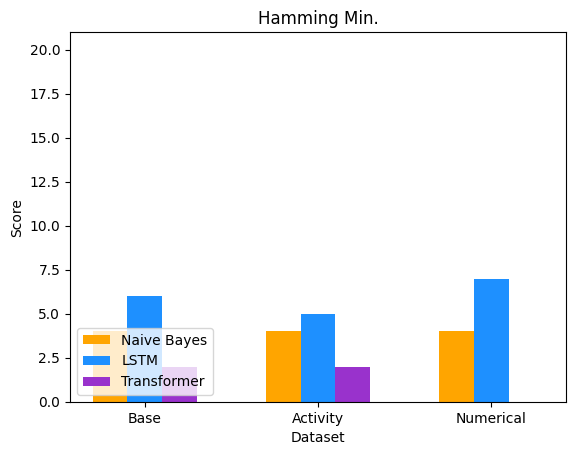

In [18]:
hist_group_by_dataset(df, "hamming_min")

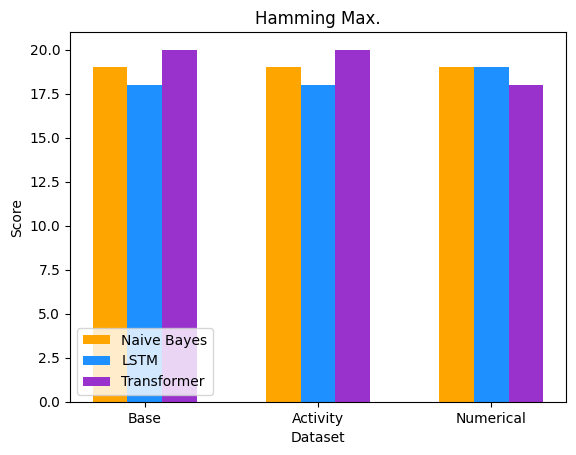

In [19]:
hist_group_by_dataset(df, "hamming_max")

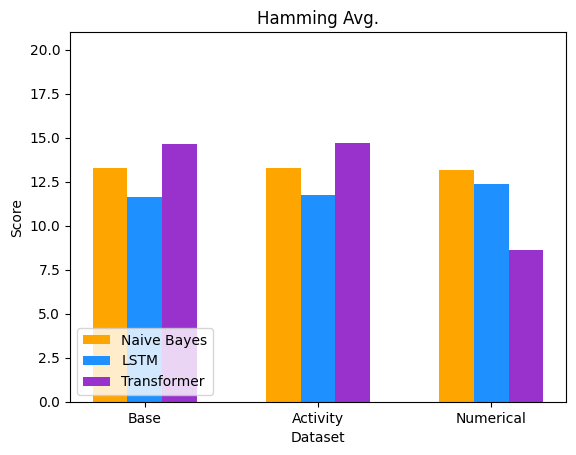

In [20]:
hist_group_by_dataset(df, "hamming_avg")

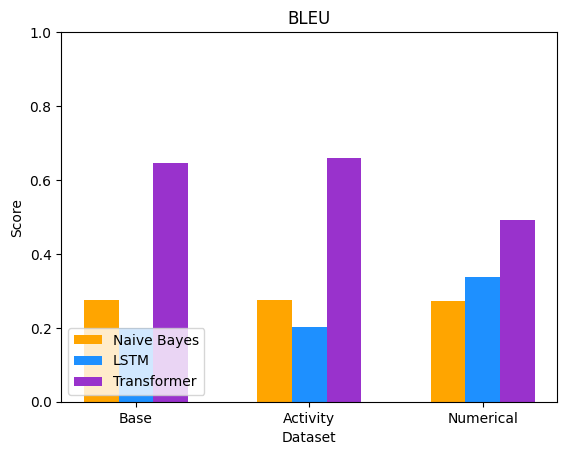

In [21]:
hist_group_by_dataset(df, "bleu")

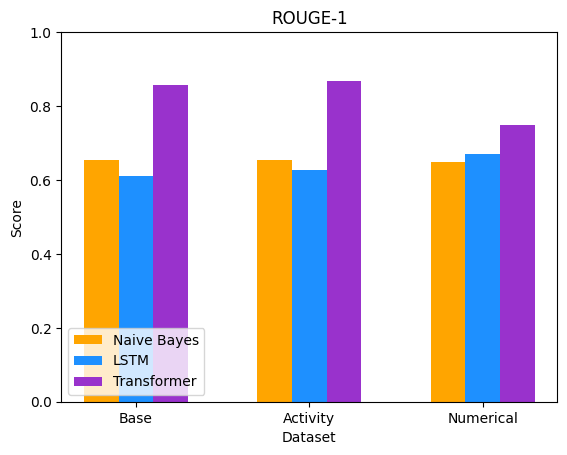

In [22]:
hist_group_by_dataset(df, "rouge_1")

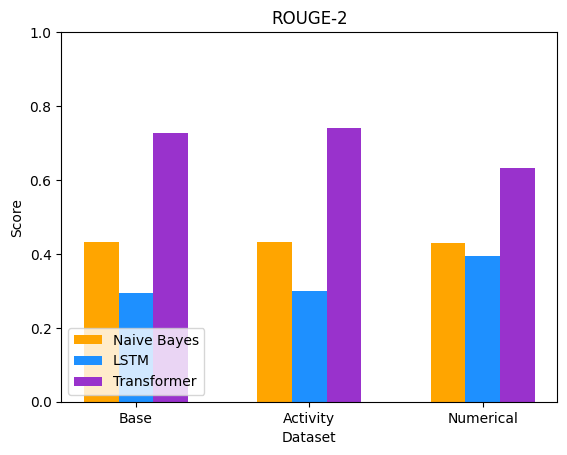

In [23]:
hist_group_by_dataset(df, "rouge_2")

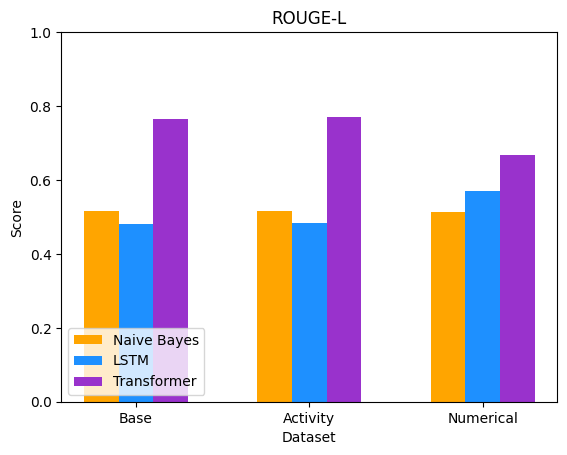

In [24]:
hist_group_by_dataset(df, "rouge_l")

# Bottom